In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration

gpus = list_physical_devices('GPU')
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=1200)])
print(len(gpus), "Physical GPUs")

2023-03-11 12:59:42.195088: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


1 Physical GPUs


2023-03-11 12:59:43.098099: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-11 12:59:43.098679: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-11 12:59:43.135514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 12:59:43.135643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-03-11 12:59:43.135661: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-11 12:59:43.137009: I tensorflow/stream_executor/platform/def

In [2]:
data = glob.glob("Data/GRBalpha/Data_firmware_3/*-*-*_*-*-*_exp*s_sbin*/ch0/rate_multi_ch.txt")
cps, d_dt = [], []
for fname in data:
    with open(fname) as file:
        lines = file.readlines()
        for line in lines[9:]:
            split = line[:-1].split()
            cps.append(float(split[-1]))

for i in range(len(cps)-1):
    d_dt.append(cps[i+1] - cps[i]) 

            

print("Number of files:",len(data))
print("Number of points:",len(cps))

df = pd.DataFrame(data = d_dt, columns=["rate"])
df

Number of files: 54
Number of points: 463779


,rate
0,3.334
1,4.333
2,-21.000
3,28.667
4,-8.334
...,...
463773,-3.000
463774,18.000
463775,1.000
463776,-1.000


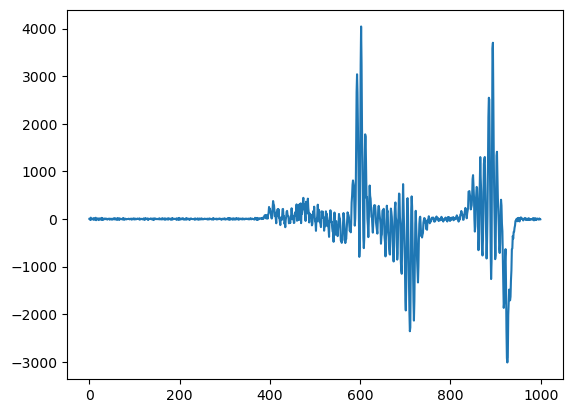

In [3]:
plt.plot(df["rate"][0:1000])

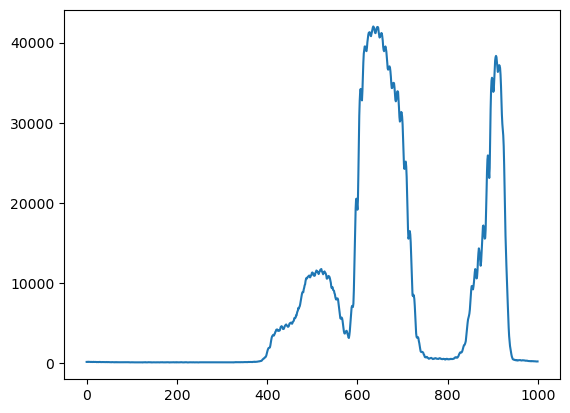

In [4]:
plt.plot(cps[0:1000])

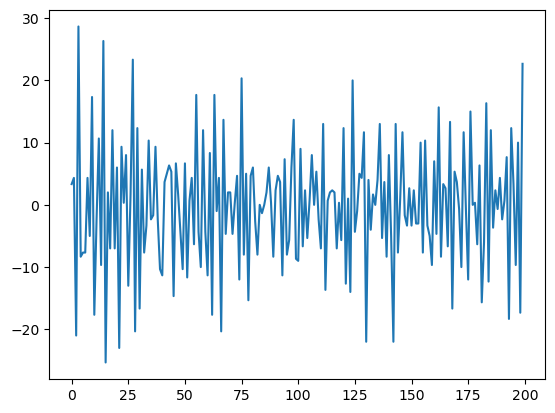

In [5]:
plt.plot(df["rate"][0:200])

In [6]:
df['rate'].to_numpy()

array([  3.334,   4.333, -21.   , ...,   1.   ,  -1.   , -15.   ])

In [7]:
def df_to_X_y(df, window_size=10):
  df_as_np = df.to_numpy()
  X,y = [], []
  for i in range(len(df_as_np)-window_size):
    X.append(df_as_np[i:i+window_size])
    y.append(df['rate'][i+window_size])
  return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 20
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

((463758, 20, 1), (463758,))

In [9]:
X_train, y_train, X_test, y_test = X1[0:400000],y1[0:400000],X1[400000:],y1[400000:]

In [10]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

2023-03-11 12:59:46.871411: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 12:59:46.871782: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-11 12:59:46.871944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 12:59:46.872095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84Gi

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [11]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())


conv_callback = [EarlyStopping(monitor='val_loss', patience=3)]


history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50,callbacks=[conv_callback])

Epoch 1/50


2023-03-11 12:59:47.641196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-11 12:59:47.641679: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3392180000 Hz
2023-03-11 12:59:48.456015: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-11 12:59:48.664460: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


12500/12500 [==============================] - 27s 2ms/step - loss: 416891.3871 - root_mean_squared_error: 645.5295 - val_loss: 623558.8125 - val_root_mean_squared_error: 789.6574
Epoch 2/50
12500/12500 [==============================] - 24s 2ms/step - loss: 385868.6805 - root_mean_squared_error: 621.1104 - val_loss: 579013.3750 - val_root_mean_squared_error: 760.9293
Epoch 3/50
12500/12500 [==============================] - 24s 2ms/step - loss: 350772.0699 - root_mean_squared_error: 592.1864 - val_loss: 545835.2500 - val_root_mean_squared_error: 738.8066
Epoch 4/50
12500/12500 [==============================] - 23s 2ms/step - loss: 324170.0588 - root_mean_squared_error: 569.2924 - val_loss: 509457.0000 - val_root_mean_squared_error: 713.7626
Epoch 5/50
12500/12500 [==============================] - 23s 2ms/step - loss: 302352.0626 - root_mean_squared_error: 549.7295 - val_loss: 487961.5312 - val_root_mean_squared_error: 698.5424
Epoch 6/50
12500/12500 [==============================] 

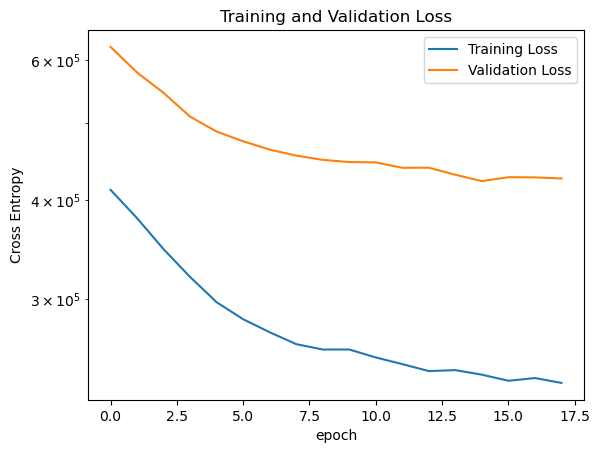

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()

In [49]:
#model1.save('models/LSTM_d_dt_nonworking')

2023-03-11 15:21:18.225053: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/LSTM_d_dt_nonworking/assets


INFO:tensorflow:Assets written to: models/LSTM_d_dt_nonworking/assets


# GRBalpha (true) detections

In [14]:
#model_d_dt = load_model('models/LSTM_d_dt')

In [15]:
data_2 = glob.glob("Data/GRBalpha/Data_firmware_2/*-*-*_*-*-*_exp*s_sbin*/ch0/part*/rate_multi_ch.txt")
cps, d_dt = [], []
for fname in data_2:
    with open(fname) as file:
        lines = file.readlines()
        for line in lines[9:]:
            split = line[:-1].split()
            cps.append(float(split[-1]))

for i in range(len(cps)-1):
    d_dt.append(cps[i+1] - cps[i]) 

            

print("Number of files:",len(data_2))
print("Number of points:",len(cps))

df_grb = pd.DataFrame(data = d_dt, columns=["rate"])
df_grb

Number of files: 522
Number of points: 173209


,rate
0,1226.50
1,-1497.50
2,71.25
3,-461.75
4,734.00
...,...
173203,40.75
173204,257.50
173205,-17.50
173206,-156.75


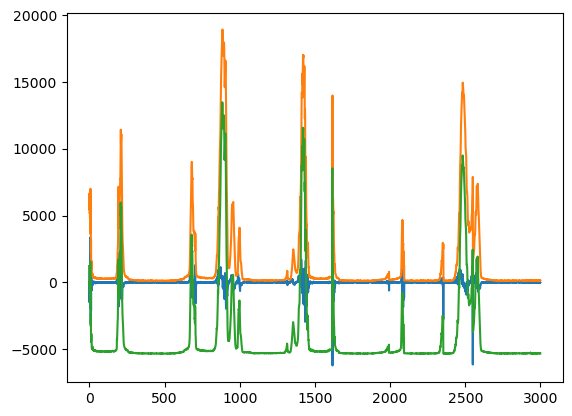

In [16]:
plt.plot(df_grb['rate'][0:3000])
plt.plot(cps[0:3000])
plt.plot(np.cumsum(df_grb['rate'][0:3000]))

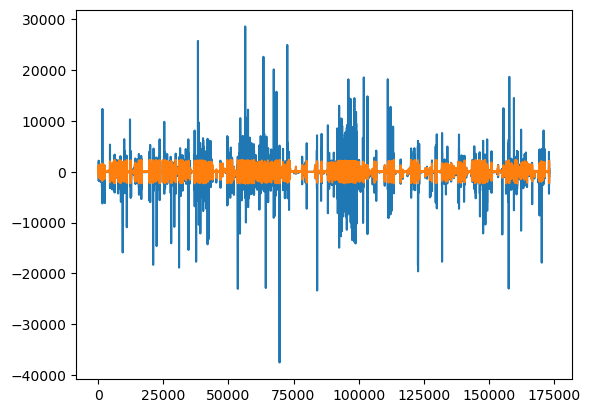

In [17]:
X1, y1 = df_to_X_y(df_grb, WINDOW_SIZE)
test_predictions = model1.predict(X1).flatten()
plt.plot(y1)
plt.plot((test_predictions))

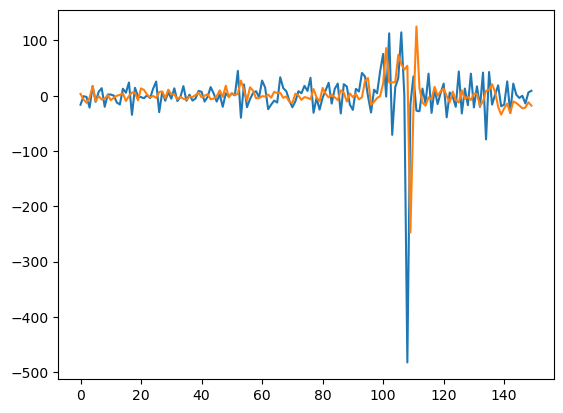

In [18]:
plt.plot(y1[4600:4750])
plt.plot((test_predictions[4600:4750]))

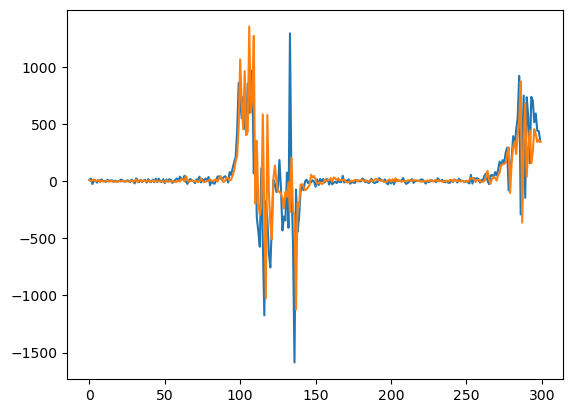

In [19]:
plt.plot(y1[550:850])
plt.plot((test_predictions[550:850]))

/tmp/ipykernel_8712/25414165.py:1: RuntimeWarning: divide by zero encountered in true_divide
  acc =(test_predictions-y1)/y1


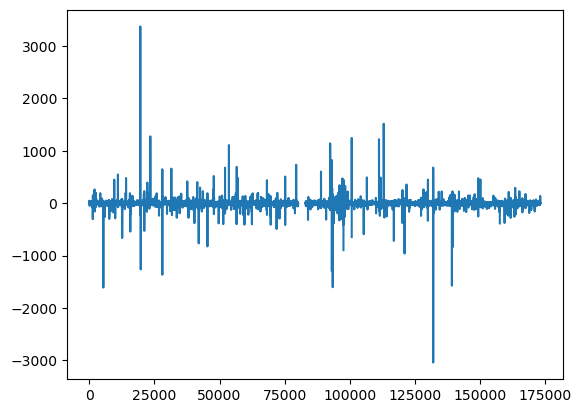

In [20]:
acc =(test_predictions-y1)/y1
plt.plot(acc)

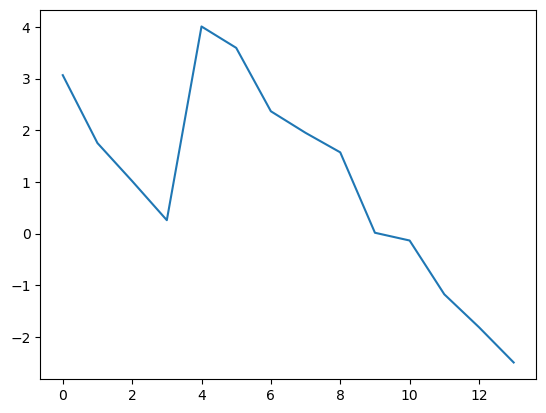

In [47]:
plt.plot(np.cumsum(acc))


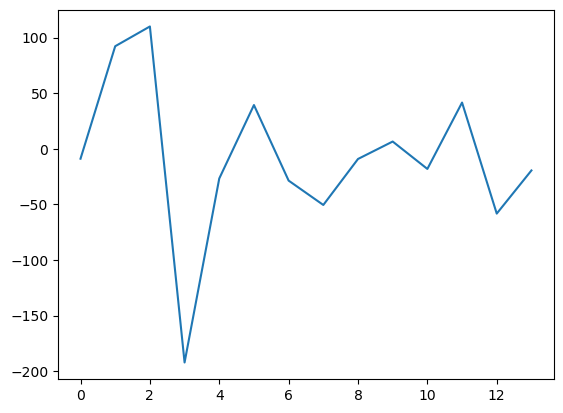

In [48]:
plt.plot(np.cumsum(acc)+y1)

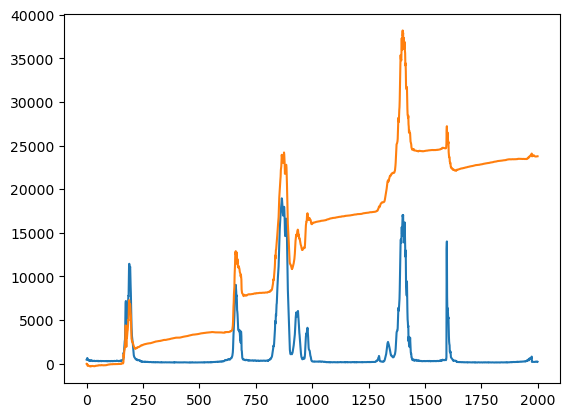

In [36]:
plt.plot(cps[0+WINDOW_SIZE:2000+WINDOW_SIZE])
plt.plot(np.cumsum(test_predictions[0:2000]))

# On training data

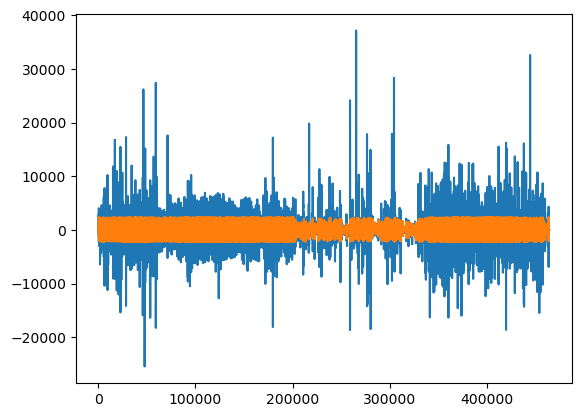

In [39]:
X2, y2 = df_to_X_y(df, WINDOW_SIZE)
test_predictions_1 = model1.predict(X2).flatten()
plt.plot(y2)
plt.plot((test_predictions_1))

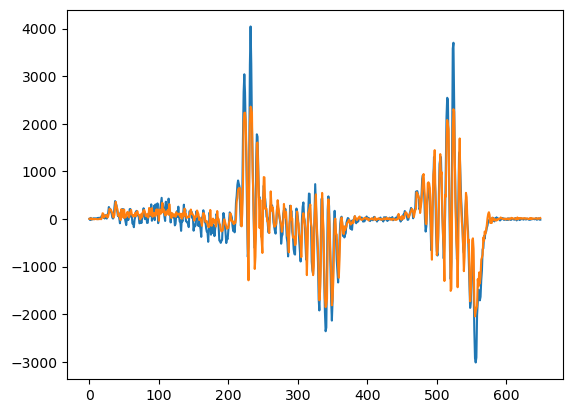

In [41]:
plt.plot(y2[350:1000])
plt.plot((test_predictions_1[350:1000]))